&nbsp;
# What will we try to do today?

<img src="./assets/datacrunch.png" width=800/>
<img src="./assets/gpustat.png" width=800/>

In [1]:
%%html
<iframe src="https://gradio.app/g/potipot/deepfashion" width="1200" height="1000"></iframe>

## The deepfashion2 dataset
The dataset used was deepfashion 2 available at https://github.com/switchablenorms/DeepFashion2

<img src="./assets/deepfashion2_bigbang.png" width=800/>

- 491K diverse images with 13 categories 
- **category**, **bounding box**, **landmarks** and **mask**
- dataset access requires filling a form

## Exploring the data

Lets display headers of our annotations file

In [2]:
import json

In [3]:
with open("/home/ppotrykus/Datasets/image/deepfasion/validation/annos/000001.json") as json_file:
    data = json.load(json_file)
    print(json.dumps(data, indent=4))

{
    "item2": {
        "segmentation": [
            [
                209.98022762018,
                194.9419398675046,
                213.54740954645825,
                204.9300492610837,
                214.14193986750462,
                211.94550704943092,
                215.92553083064374,
                244.64467470698156,
                218.18474605061996,
                260.2213691183966,
                219.492712756922,
                264.73979955834903,
                216.87677934431795,
                265.09651775097683,
                215.09318838117883,
                266.04776626465105,
                211.73473755732974,
                281.6862918294547,
                206.97849498895874,
                306.7754713776117,
                207.5730253100051,
                328.1785629352812,
                211.1088160353321,
                379.2407677934431,
                211.94115848479703,
                396.3632410395787,
                215.38

**Annotations come in custom format.**

<img src="./assets/sad-face.png" width=80/>

Instead of writing a custom parser I decided to use the attached `deepfashion_to_coco.py` script to convert annotation files to COCO.

In [4]:
with open("datasets/validation.json") as json_file:
    data = json.load(json_file)
    print(json.dumps(data, indent=4)[:630])

{
    "info": {},
    "licenses": [],
    "images": [
        {
            "coco_url": "",
            "date_captured": "",
            "file_name": "image/021051.jpg",
            "flickr_url": "",
            "id": 21051,
            "license": 0,
            "width": 640,
            "height": 960
        },
        {
            "coco_url": "",
            "date_captured": "",
            "file_name": "image/013489.jpg",
            "flickr_url": "",
            "id": 13489,
            "license": 0,
            "width": 880,
            "height": 1320
        },
        {
            "coco_url": "",
            "date


<img src="./assets/pepe-happy.jpeg" width=80/>

&nbsp;
# Preparing the data
## Using COCO parser to create records

In [1]:
from icevision.all import *
import icedata

Some helper function that handles COCO-style datasets

In [2]:
def deepfashion_dataset(
        root_dir:Union[Path, str],
        mask: bool = False,
        autofix: bool = True,
        cache_records: bool = True
) -> Tuple[tuple, ClassMap]:

    if isinstance(root_dir, str): root_dir = Path(root_dir)
    coco_train = icedata.coco.parser(
        img_dir=root_dir / 'train',
        annotations_file='./datasets/train.json',
        mask=mask)

    coco_valid = icedata.coco.parser(
        img_dir=root_dir / 'validation',
        annotations_file='./datasets/validation.json',
        mask=mask)

    train_records, *_ = coco_train.parse(data_splitter=SingleSplitSplitter(), autofix=autofix,
                                         cache_filepath=root_dir / 'train_cache' if cache_records else None)
    valid_records, *_ = coco_valid.parse(data_splitter=SingleSplitSplitter(), autofix=autofix,
                                         cache_filepath=root_dir / 'valid_cache' if cache_records else None)

    assert(coco_train.class_map==coco_valid.class_map), f"ClassMap for train and valid differ: {coco_train.class_map=}!={coco_valid.class_map=}"
    return (train_records, valid_records), coco_train.class_map

My annotations files are already parsed and autofixed. We can use caching to speed up the loading of our annotations.  

**NOTE: !Remember to refresh/delete your cache if you update annotation files!** 

## OmegaConf
Handy config and hyperparameters: [**OmegaConf**](https://github.com/omry/omegaconf)

In [3]:
from omegaconf import OmegaConf

In [4]:
params = OmegaConf.create({
    'img_size': 512,
    'num_classes': 14,
    'bs': 4,
    'num_workers': 4,
    'path': './datasets',
    'model_name': 'tf_efficientdet_d1'
})

In [5]:
(train_records, valid_records), class_map = deepfashion_dataset(params.path, autofix=True)

INFO     - Loading cached records from datasets/train_cache | icevision.parsers.parser:parse:121
INFO     - Loading cached records from datasets/valid_cache | icevision.parsers.parser:parse:121



## Now let's see our record files!

In [6]:
class_map._id2class

['background',
 'short_sleeved_shirt',
 'long_sleeved_shirt',
 'short_sleeved_outwear',
 'long_sleeved_outwear',
 'vest',
 'sling',
 'shorts',
 'trousers',
 'skirt',
 'short_sleeved_dress',
 'long_sleeved_dress',
 'vest_dress',
 'sling_dress']

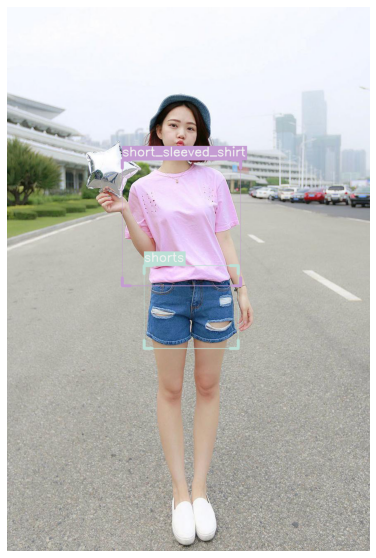

In [7]:
show_record(train_records[10], display_label=True, class_map=class_map, figsize=(10,10))


## Defining augmentations and dataloaders

\
Limiting rotation angle

In [8]:
aug_tfms = tfms.A.aug_tfms(
    size=params.img_size,
    shift_scale_rotate=tfms.A.ShiftScaleRotate(rotate_limit=(-15, 15)),
)
aug_tfms.append(tfms.A.Normalize())

\
Let's see what our augmentations are

In [9]:
aug_tfms

[HorizontalFlip(always_apply=False, p=0.5),
 ShiftScaleRotate(always_apply=False, p=0.5, shift_limit_x=(-0.0625, 0.0625), shift_limit_y=(-0.0625, 0.0625), scale_limit=(-0.09999999999999998, 0.10000000000000009), rotate_limit=(-15, 15), interpolation=1, border_mode=4, value=None, mask_value=None),
 RGBShift(always_apply=False, p=0.5, r_shift_limit=(-20, 20), g_shift_limit=(-20, 20), b_shift_limit=(-20, 20)),
 RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
 Blur(always_apply=False, p=0.5, blur_limit=(1, 3)),
 OneOrOther([
   RandomSizedBBoxSafeCrop(always_apply=False, p=0.5, height=512, width=512, erosion_rate=0.0, interpolation=1),
   LongestMaxSize(always_apply=False, p=1, max_size=512, interpolation=1),
 ], p=0.5),
 PadIfNeeded(always_apply=False, p=1.0, min_height=512, min_width=512, pad_height_divisor=None, pad_width_divisor=None, border_mode=0, value=[124, 116, 104], mask_value=None),
 Normalize

\
Coupling it together

In [10]:
train_tfms = tfms.A.Adapter(aug_tfms)
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(params.img_size), tfms.A.Normalize()])

train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

train_dl = efficientdet.train_dl(train_ds, batch_size=params.bs, num_workers=params.num_workers, shuffle=True)
valid_dl = efficientdet.valid_dl(valid_ds, batch_size=params.bs, num_workers=params.num_workers, shuffle=False)

## Looking at the batch

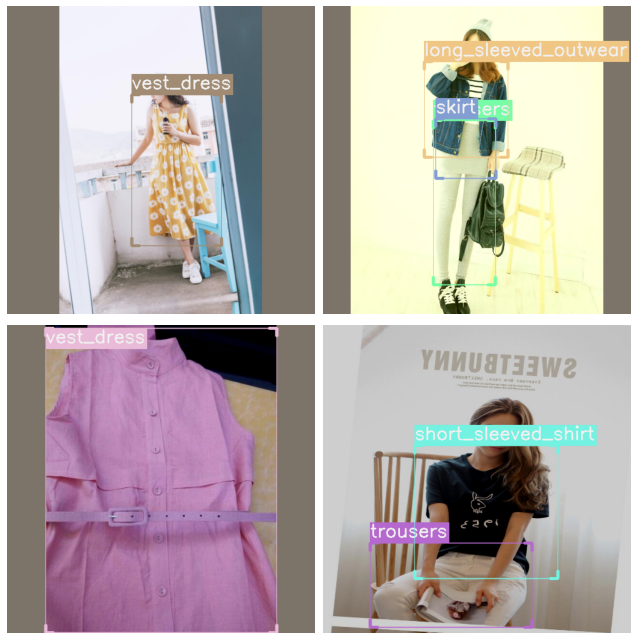

In [11]:
batch, samples = first(train_dl)
show_samples(samples[:6], class_map=class_map, ncols=2, figsize=(9,9))

&nbsp;
# EfficientDet Model
<img src="./assets/efficientdet.png" width=600/>
<img src="./assets/efficientdet_table.png" width=600/>

## Following the tutorial...

In [12]:
print(OmegaConf.to_yaml(params))

img_size: 512
num_classes: 14
bs: 4
num_workers: 4
path: ./datasets
model_name: tf_efficientdet_d1



In [13]:
model = efficientdet.model(model_name=params.model_name, num_classes=params.num_classes, img_size=params.img_size)
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [14]:
learn = efficientdet.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

In [15]:
learn.freeze()
learn.lr_find()

KeyboardInterrupt: 

<img src="./assets/pepe-happy.jpeg" width=80/>

In [16]:
from fastai.learner import AvgLoss
from fastai.torch_core import find_bs

@patch
def accumulate(self:AvgLoss, learn):
    #bs = find_bs(learn.yb)
    bs = find_bs(learn.xb)
    self.total += learn.to_detach(learn.loss.mean())*bs
    self.count += bs

In [ ]:
learn.fine_tune(10, 1e-2, freeze_epochs=3)

<details>
    <summary>nan</summary>
<img src="./assets/fastai-nan.png" width=600/>
</details>

<details>
    <summary>github issue</summary>
    <img src="./assets/nan-github.png" width=900/>
    <br>
    <img src="./assets/sad-face.png" width=80/>
</details>

## Timm to the rescue!
Here is where the fun part begins. 
Training efficientdet models with [timm](https://github.com/rwightman/pytorch-image-models/tree/master/timm) library.

```python
from timm.optim import create_optimizer
from timm.scheduler import create_scheduler


@dataclass
class TimmConfig:
    opt:str = 'fusedmomentum'
    weight_decay:float = 4e-5
    lr: float = 0.01
    momentum: float = 0.9

    opt_eps: float = 1e-3
    # opt_betas
    # opt_args

    epochs: int = 300
    lr_noise: tuple = (0.4, 0.9)
    sched: str = 'cosine'
    min_lr: float = 1e-5
    decay_rate: float = 0.1
    warmup_lr: float = 1e-4
    warmup_epochs: int = 5
    cooldown_epochs: int = 10

    lr_cycle_limit:int = 1
    lr_cycle_mul: float = 1.0
    lr_noise_pct: float = 0.67
    lr_noise_std: float = 1.0
    seed: int = 42

# Pytorch lightning
class BaseModel(efficientdet.lightning.ModelAdapter):
    def __init__(self, model: nn.Module, metrics: List[Any] = None, **timm_args):
        super(BaseModel, self).__init__(model=model, metrics=metrics)
        self.n_train_dls, self.n_test_dls, self.n_valid_dls = None, None, None
        self.timm_config = TimmConfig(**timm_args)

    def configure_optimizers(self):
        optimizer = create_optimizer(self.timm_config, self.model)
        lr_scheduler, num_epochs = create_scheduler(self.timm_config, optimizer)
        return [optimizer], [lr_scheduler]
```

It was almost as simple as that!  
Pending PR (https://github.com/PyTorchLightning/pytorch-lightning/pull/5898)

## Transfer learning

Thanks to IceVision being backend agnostic, everything we created so far will still work in pytorch lightning!

In [17]:
from icevision_detector import *

In [18]:
from omegaconf import OmegaConf
params = OmegaConf.create({
    'project': 'deepfashion-presentation',
    'run_name': 'presentation',
    'img_size': 512,
    'num_classes': 14,
    'bs': 4,
    'num_workers': 4,
    'path': './datasets',
    'model_name': 'tf_efficientdet_d1'
})

In [19]:
light_model = EffDetModel(
    num_classes=params.num_classes, img_size=params.img_size, model_name=params.model_name,
    lr=0.12, warmup_epochs=2)

## Freezing/unfreezing

In [20]:
light_model.freeze_to_head(True, True)

In [21]:
trainer = pl.Trainer(
    # limit_train_batches=1000,
    # limit_val_batches=100,
    gpus=1,
    max_epochs=3,
    sync_batchnorm=True,  # from Ross'es training config
    weights_summary='top' # print top-level modules summary
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


## Training

In [34]:
trainer.fit(light_model, train_dl, valid_dl)


  | Name  | Type          | Params
----------------------------------------
0 | model | DetBenchTrain | 6.6 M 
----------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params


Validation sanity check: 0it [00:00, ?it/s]

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000


Training: 0it [00:00, ?it/s]

/home/ppotrykus/anaconda3/envs/deepfashion/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

<img src="./assets/pepe-happy.jpeg" width=80/>

**NOTE: epoch time and GPU load**

&nbsp;
&nbsp;

# Going big
- we've read our label files and created the records
- we defined transforms and dataloaders
- we defined optimizers and schedulers
- we chose the model and used pretrained weights


## Experiment tracking with wandb
<img src="./assets/wandb_plot.png" width=600/>

What is wandb?

In [22]:
from pytorch_lightning.loggers import WandbLogger

In [23]:
wandb_logger = WandbLogger(project=params.project, name=params.run_name)

In [24]:
from pytorch_lightning.callbacks import LearningRateMonitor

In [25]:
lr_monitor = LearningRateMonitor(log_momentum=True)

## Setup model checkpointing

In [26]:
from pytorch_lightning.callbacks import ModelCheckpoint

In [27]:
checkpoint_callback = ModelCheckpoint(
    verbose=True,
    monitor='COCOMetric/AP (IoU=0.50) area=all/dl_idx_0',
    mode='max'
)

## Try our new trainer setup

In [28]:
trainer = pl.Trainer(
    gpus=1,
    max_epochs=3,
    sync_batchnorm=True,  # from Ross'es training config
    weights_summary='top', # print top-level modules summary
    logger=wandb_logger,
    callbacks=[lr_monitor, checkpoint_callback],
    amp_level='O2',  # mixed precision
    precision=16,
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


In [29]:
light_model = EffDetModel(
    num_classes=params.num_classes, img_size=params.img_size, model_name=params.model_name,
    lr=0.12, warmup_epochs=2)

wandb: Currently logged in as: potipot (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.20 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name  | Type          | Params
----------------------------------------
0 | model | DetBenchTrain | 6.6 M 
----------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params


Validation sanity check: 0it [00:00, ?it/s]

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.006
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.006


Training: 0it [00:00, ?it/s]

/home/ppotrykus/anaconda3/envs/deepfashion/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Trying to log at a previous step. Use `commit=False` when logging metrics manually.
  warnings.warn(*args, **kwargs)
wandb: WARNING Step must only increase in log calls.  Step 0 < 1; dropping {'lr-FusedSGD/pg1': 0.0001, 'lr-FusedSGD-momentum/pg1': 0.9, 'lr-FusedSGD/pg2': 0.0001, 'lr-FusedSGD-momentum/pg2': 0.9}.
/home/ppotrykus/anaconda3/envs/deepfashion/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


MisconfigurationException: ModelCheckpoint(monitor='COCOMetric/AP (IoU=0.50) area=all/dl_idx_0') not found in the returned metrics: ['train/loss', 'train/class_loss', 'train/box_loss']. HINT: Did you call self.log('COCOMetric/AP (IoU=0.50) area=all/dl_idx_0', tensor) in the LightningModule?

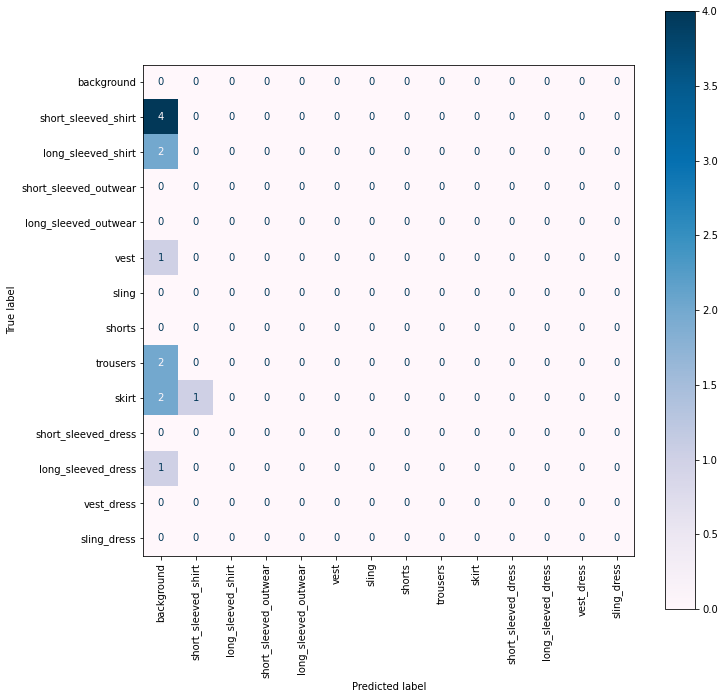

In [30]:
trainer.fit(light_model, train_dl, valid_dl)

## Multi-GPU training

In [31]:
trainer = pl.Trainer(
    gpus=2,
    accelerator='ddp',
    logger=wandb_logger,
    callbacks=[lr_monitor, checkpoint_callback],
    max_epochs=300, # caveat
    sync_batchnorm=True,  # from Ross'es training config
    weights_summary='full',
    amp_level='O2', 
    precision=16,
)

MisconfigurationException: 
                You requested GPUs: [0, 1]
                But your machine only has: [0]
            

<details>
    <summary>well</summary>
<img src="./assets/guess.jpg" width=400/>
</details>

## Exporting training script

In [32]:
!jupyter nbconvert \
    --TagRemovePreprocessor.enabled=True \
    --TagRemovePreprocessor.remove_cell_tags="['no-script']" \
    --TemplateExporter.exclude_markdown=True \
    --to python "presentation-25.02.20.ipynb" \
    --output "train.py"

/home/ppotrykus/anaconda3/envs/deepfashion/lib/python3.8/site-packages/traitlets/traitlets.py:2556: FutureWarning: --TagRemovePreprocessor.remove_cell_tags=['no-script'] for containers is deprecated in traitlets 5.0. You can pass `--TagRemovePreprocessor.remove_cell_tags item` ... multiple times to add items to a list.
  warn(
[NbConvertApp] Converting notebook presentation-25.02.20.ipynb to python
[NbConvertApp] Writing 3034 bytes to train.py


...and let's take a look

## Exporting environment files

```bash
conda env export > environment.yml
```
**Whats the caveat? - cross-platform**

In [33]:
!cat environment.yml

name: icevision_detector
channels:
  - pytorch
  - conda-forge
  - defaults
dependencies:
  - python=3.8
  - pip==20.2.0
  - notebook=6.1.6
  - numpy
  - pip:
    - -r file:requirements.txt

In [34]:
!cat requirements.txt

ipywidgets==7.6.3
timm==0.3.4
icevision[all]==0.6.0b1
git+git://github.com/potipot/pytorch-lightning@feature/5555_add_timm_support
icedata==0.2.0
wandb==0.10.13
gradio==1.5.3
#[-v --disable-pip-version-check --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext"] git+git://github.com/NVIDIA/apex



## Check our TODO list
```diff
+ create training script
+ create conda environment.yml and pip requirements.txt files
- create cloud isntance config script
- push everything to git
```

&nbsp;
# Creating multi-gpu cloud instance

## Go to [datacrunch](https://cloud.datacrunch.io/signin)
discount code: `Crunch10%`  

[link](https://cloud.datacrunch.io/signin)
## Choose instance type and image
<img src="./assets/datacrunch.png" width=600/>

## Setup ssh key - watch out for linebreaks when copying from terminal!
[How to generate ssh key](https://www.ssh.com/ssh/keygen/)
```bash
cat ~/.ssh/id_rsa.pub | xclip -selection c
```


## Setup config script
```bash
#!/bin/bash

sudo apt-get update
sudo apt install -y gcc python3-dev python3-pip libxml2-dev libxslt1-dev zlib1g-dev g++ unzip ninja-build

# create user
myusername=ppotrykus
adduser --disabled-password --shell /bin/bash --gecos "" $myusername
usermod -aG sudo $myusername

# copy ssh keys
cp -R ~/.ssh /home/$myusername/.
sudo chown -R $myusername /home/$myusername/.ssh

# set password
usermod --password $(echo nvidia | openssl passwd -1 -stdin) $myusername

# install anaconda
curl https://repo.anaconda.com/archive/Anaconda3-2020.11-Linux-x86_64.sh -o anaconda.sh
bash anaconda.sh -b -p /opt/anaconda3
sudo -Hu $myusername bash -c 'source /opt/anaconda3/bin/activate && conda init'
# source .bashrc when using ssh
printf "if [ -f ~/.bashrc ]; then\n    . ~/.bashrc\nfi\n" >> /home/$myusername/.profile
```


## Deploy!
<img src="./assets/deploy.jpg" width=400/>

## Connect to your instance using ssh
```bash
ssh -i ~/.ssh/id_rsa ppotrykus@135.181.63.154
```

If conda is not active, run:
```bash
source /opt/anaconda3/bin/activate
```

Start a tmux session to allow access to many shells:
```bash
tmux new -s remote
```

## Clone the repo and configure training env
```bash
git clone https://github.com/potipot/deepfashion --recurse-submodules
```
**What happens in startup.sh?**
```bash
cd deepfashion
bash startup.sh
```

## Let's train!
Install gpustat  

<img src="./assets/gpustat.png" width=700/>

&nbsp;
# Training on Multiple GPUs with fastai?

# *Impressing your supervisor with wandb reports*

In [7]:
%%html
<iframe src="https://wandb.ai/potipot/deepfashion/reports/Deepfashion-Detector--Vmlldzo0NzMwMDg?accessToken=j3hb8z4lkjys7j5fp41x3z8nc2g3d3uj4uku4xg9bruy8bu2gilt6qztmxbo4e7r" width="1200" height="1000"></iframe>

```
```
# Deployment - WiP
## Inference
## gradio model deployment